In [35]:
## Code used from medium article by Mauro Di Pietro at https://towardsdatascience.com/time-series-analysis-for-machine-learning-with-python-626bee0d0205

## For data
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt

## For outliers detection
from sklearn import preprocessing, svm

## For stationarity test and decomposition
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [4]:
dtf = pd.read_csv('./PredictSales/sales_train.csv')
                  
dtf.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
## format datetime column
dtf["date"] = pd.to_datetime(dtf['date'], format='%d.%m.%Y')

## create time series
ts = dtf.groupby("date")["item_cnt_day"].sum().rename("sales")

ts.head()

date
2013-01-01    1951.0
2013-01-02    8198.0
2013-01-03    7422.0
2013-01-04    6617.0
2013-01-05    6346.0
Name: sales, dtype: float64

In [6]:
ts.tail()

date
2015-10-27    1551.0
2015-10-28    3593.0
2015-10-29    1589.0
2015-10-30    2274.0
2015-10-31    3104.0
Name: sales, dtype: float64

<AxesSubplot:xlabel='date'>

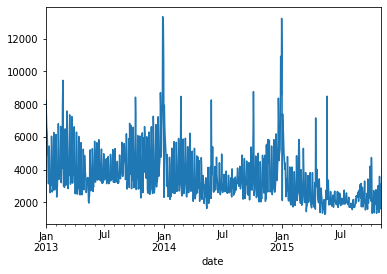

In [7]:
ts.plot()

## Trend Line Analysis

In [8]:
'''
Plot ts with rolling mean and 95% confidence interval with rolling std.
:parameter    
  :param ts: pandas Series    
  :param window: num - for rolling stats
  :param plot_ma: bool - whether plot moving average
  :param plot_intervals: bool - whether plot upper and lower bounds
'''
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=30,
            figsize=(15,5)):    
   rolling_mean = ts.rolling(window=window).mean()    
   rolling_std = ts.rolling(window=window).std()
   plt.figure(figsize=figsize)    
   plt.title(ts.name)    
   plt.plot(ts[window:], label='Actual values', color="black")    
   if plot_ma:        
      plt.plot(rolling_mean, 'g', label='MA'+str(window),
               color="red")    
   if plot_intervals:
      lower_bound = rolling_mean - (1.96 * rolling_std)
      upper_bound = rolling_mean + (1.96 * rolling_std)
   plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                    color='lightskyblue', alpha=0.4)
   plt.legend(loc='best')
   plt.grid(True)
   plt.show()

In [9]:
print("population --> len:", len(ts), "| mean:", round(ts.mean()), " | std:", round(ts.std()))
w = 30
print("moving --> len:", w, " | mean:", round(ts.ewm(span=w).mean()[-1]), " | std:", round(ts.ewm(span=w).std()[-1]))

population --> len: 1034 | mean: 3528  | std: 1585
moving --> len: 30  | mean: 2305  | std: 773


/tmp/ipykernel_1923220/4147100072.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA'+str(window),


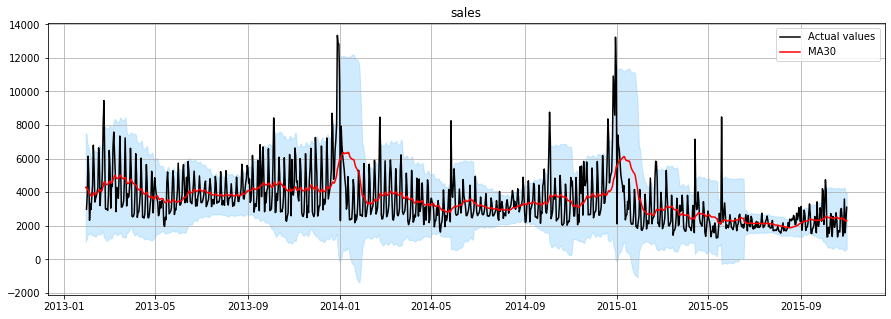

In [10]:
plot_ts(ts, window=30)

/tmp/ipykernel_1923220/4147100072.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA'+str(window),


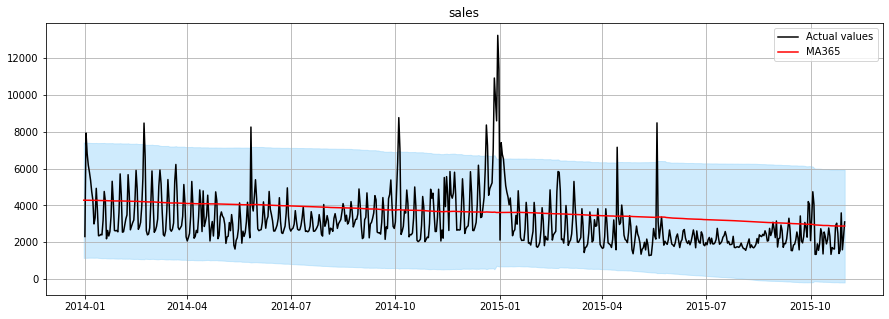

In [12]:
plot_ts(ts, window=365)

## Detecting Outliers

<AxesSubplot:>

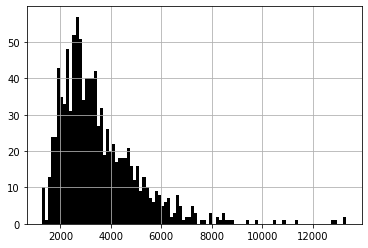

In [13]:
## Plot histogram
ts.hist(color="black", bins=100)

<AxesSubplot:>

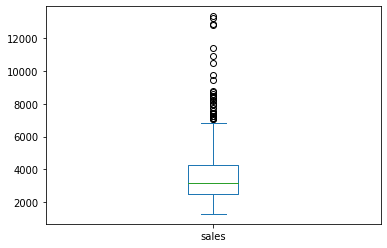

In [14]:
## Boxplot
ts.plot.box()

In [15]:
'''
Find outliers using sklearn unsupervised support vetcor machine.
:parameter
    :param ts: pandas Series
    :param perc: float - percentage of outliers to look for
:return
    dtf with raw ts, outlier 1/0 (yes/no), numeric index
'''
def find_outliers(ts, perc=0.01, figsize=(15,5)):
    ## fit svm
    scaler = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))
    model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)
    ## dtf output
    dtf_outliers = ts.to_frame(name="ts")
    dtf_outliers["index"] = range(len(ts))
    dtf_outliers["outlier"] = model.predict(ts_scaled)
    dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                              x: 1 if x==-1 else 0)
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title="Outliers detection: found"
           +str(sum(dtf_outliers["outlier"]==1)))
    ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
            color="black")
    ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
               y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
               color='red')
    ax.grid(True)
    plt.show()
    return dtf_outliers

In [16]:
'''
Interpolate (Remove) outliers in a time series.
'''
def remove_outliers(ts, outliers_idx, figsize=(15,5)):
    ts_clean = ts.copy()
    ts_clean.loc[outliers_idx] = np.nan
    ts_clean = ts_clean.interpolate(method="linear")
    ax = ts.plot(figsize=figsize, color="red", alpha=0.5,
         title="Remove outliers", label="original", legend=True)
    ts_clean.plot(ax=ax, grid=True, color="black",
                  label="interpolated", legend=True)
    plt.show()
    return ts_clean

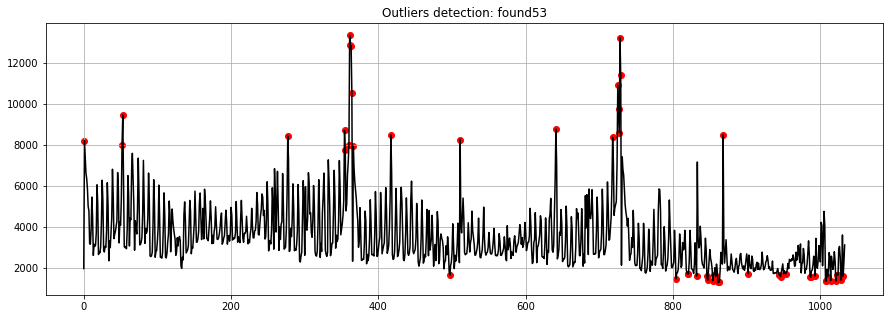

In [17]:
dtf_outliers = find_outliers(ts, perc=0.05)

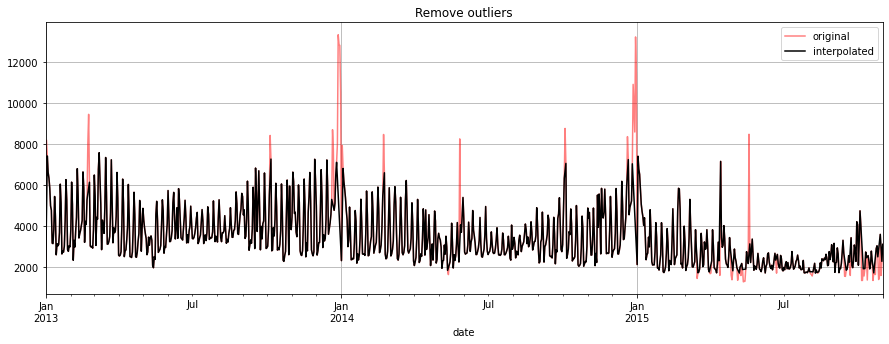

In [18]:
## outliers index position
outliers_index_pos = dtf_outliers[dtf_outliers["outlier"]==1].index

## exclude outliers
ts_clean = remove_outliers(ts, outliers_idx=outliers_index_pos)

## Stationary Test

A stationary process is a stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently, parameters such as mean and variance also do not change over time

In [30]:
def test_stationarity_acf_pacf(ts, sample=0.20, maxlag=30, figsize=(15,10)):
    with plt.style.context(style='bmh'):
        ## set figure
        fig = plt.figure(figsize=figsize)
        ts_ax = plt.subplot2grid(shape=(2,2), loc=(0,0), colspan=2)
        pacf_ax = plt.subplot2grid(shape=(2,2), loc=(1,0))
        acf_ax = plt.subplot2grid(shape=(2,2), loc=(1,1))
        
        ## plot ts with mean/std of a sample from the first x% 
        dtf_ts = ts.to_frame(name="ts")
        sample_size = int(len(ts)*sample)
        dtf_ts["mean"] = dtf_ts["ts"].head(sample_size).mean()
        dtf_ts["lower"] = dtf_ts["ts"].head(sample_size).mean() + dtf_ts["ts"].head(sample_size).std()
        dtf_ts["upper"] = dtf_ts["ts"].head(sample_size).mean() - dtf_ts["ts"].head(sample_size).std()
        dtf_ts["ts"].plot(ax=ts_ax, color="black", legend=False)
        dtf_ts["mean"].plot(ax=ts_ax, legend=False, color="red", linestyle="--", linewidth=0.7)
        ts_ax.fill_between(x=dtf_ts.index, y1=dtf_ts['lower'], y2=dtf_ts['upper'], color='lightskyblue', alpha=0.4)
        dtf_ts["mean"].head(sample_size).plot(ax=ts_ax, legend=False, color="red", linewidth=0.9)
        ts_ax.fill_between(x=dtf_ts.head(sample_size).index, y1=dtf_ts['lower'].head(sample_size), y2=dtf_ts['upper'].head(sample_size), color='lightskyblue')
        ts_ax.set(xlabel=None)

        ## test stationarity (Augmented Dickey-Fuller)
        adfuller_test = sm.tsa.stattools.adfuller(ts, maxlag=maxlag, autolag="AIC")
        adf, p, critical_value = adfuller_test[0], adfuller_test[1], adfuller_test[4]["5%"]
        p = round(p, 3)
        conclusion = "Stationary" if p < 0.05 else "Non-Stationary"
        ts_ax.set_title('Dickey-Fuller Test 95%: '+conclusion+' (p-value: '+str(p)+')')
        
        ## pacf (for AR) e acf (for MA) 
        smt.graphics.plot_pacf(ts, lags=maxlag, ax=pacf_ax, title="Partial Autocorrelation (for AR component)")
        smt.graphics.plot_acf(ts, lags=maxlag, ax=acf_ax, title="Autocorrelation (for MA component)")
        plt.tight_layout()

/home/corey/anaconda3/envs/forecastingEnv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


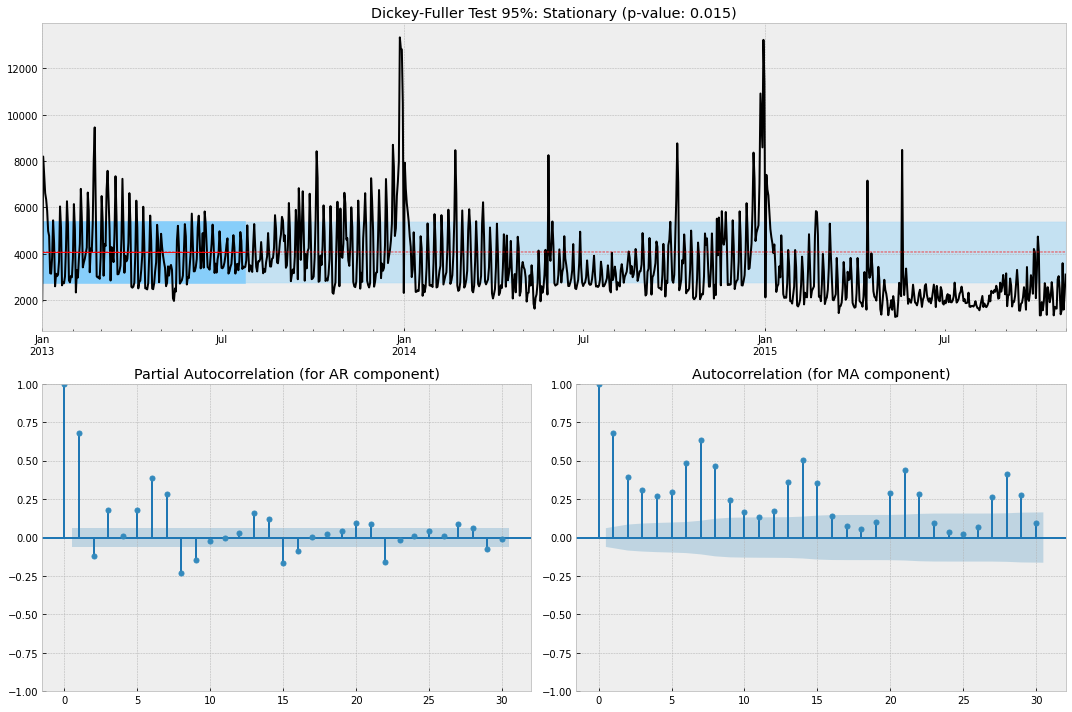

In [31]:
test_stationarity_acf_pacf(ts, sample=0.20, maxlag=30)

## Differencing the Time Series

Differencing can help stabilize the mean by removing changes in the level of observations, and therefore eliminating (or reducing) trend and seasonality. Basically we will apply the following transformation

/home/corey/anaconda3/envs/forecastingEnv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


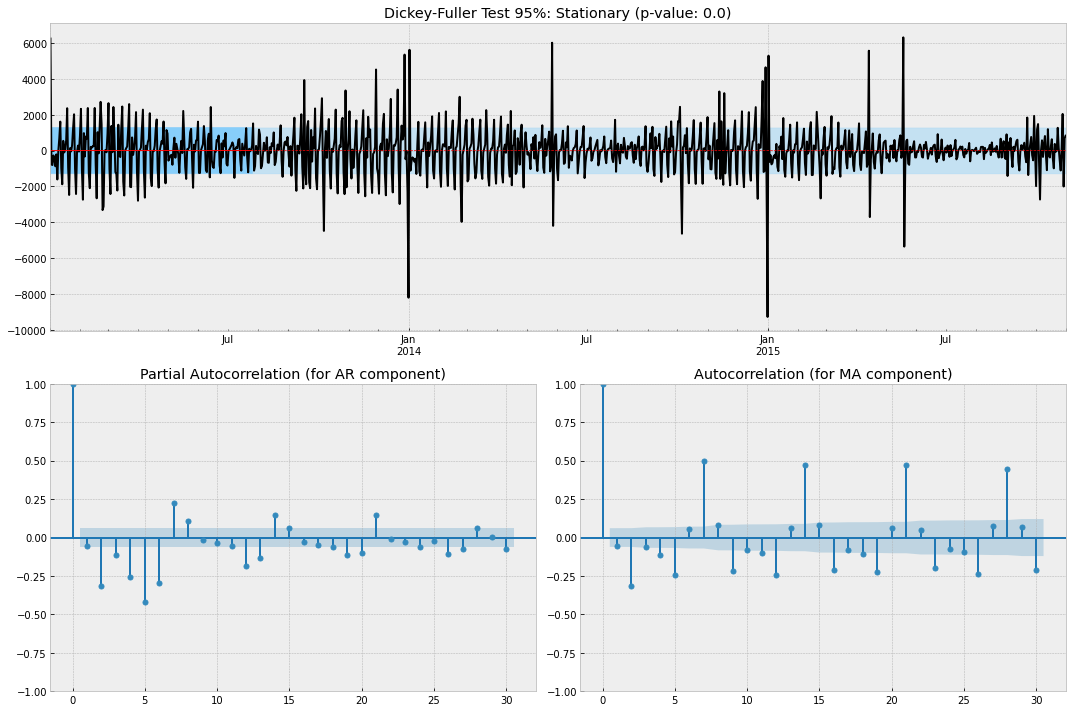

In [32]:
diff_ts = ts - ts.shift(1)
diff_ts = diff_ts[(pd.notnull(diff_ts))]

test_stationarity_acf_pacf(diff_ts, sample=0.20, maxlag=30)

## Seasonality Analysis 


The seasonal component is that part of the variations in a time series representing intra-year fluctuations that are more or less stable year after year with respect to timing, direction and magnitude.

The objectiv is to understand what kind of seasonality is affecting the data (weekly seasonality if it presents fluctuations every 7 days, monthly seasonality if it presents fluctuations every 30 days, and so on).

This is crucial for the model design part that comes after this analysis session. In particular, when working with seasonal autoregressive models you must specify the number of observations per season: I’m talking about the parameter “s” in SARIMA (p, d, q)x(P, D, Q, s).
There is a super useful function into the statsmodel library that allows us to decompose the time series. This function splits the data into 3 components: trend, seasonality and residuals.

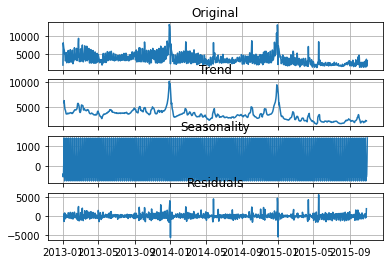

In [34]:
decomposition = smt.seasonal_decompose(ts, period=7)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid   
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False)
ax[0].plot(ts)
ax[0].set_title('Original')
ax[0].grid(True) 
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[1].grid(True)  
ax[2].plot(seasonal)
ax[2].set_title('Seasonality')
ax[2].grid(True)  
ax[3].plot(residual)
ax[3].set_title('Residuals')
ax[3].grid(True)